### Using PYtorch to accomplish 2 layer neural network 

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Step 1: Loading the CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# Step 3: Define the Neural Network Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)  # Input size is 32x32x3 (CIFAR-10 images)
        self.fc2 = nn.Linear(512, 10)  # Output size is 10 classes

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Flatten input tensor
        x = torch.relu(self.fc1(x))  # Apply ReLU activation function
        x = self.fc2(x)
        return x

net = Net()

# Step 4: Specify Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Step 5: Training the Model
for epoch in range(10):  # Train for 10 epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:  # Print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    print('Epoch %d, Loss: %.3f' % (epoch + 1, running_loss / len(trainloader)))      
print('Finished Training')

# Step 6: Evaluate the Model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))



Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.880
Epoch 2, Loss: 1.656
Epoch 3, Loss: 1.572
Epoch 4, Loss: 1.514
Epoch 5, Loss: 1.469
Epoch 6, Loss: 1.428
Epoch 7, Loss: 1.393
Epoch 8, Loss: 1.358
Epoch 9, Loss: 1.327
Epoch 10, Loss: 1.298
Finished Training
Accuracy of the network on the 10000 test images: 51 %


In [20]:
print(f'\n losses={running_loss}\n')


 losses=1014.7645643353462



# Target percentage= 51%

## Implementing Custom 2-layer Neural Network using numpy arrays

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.datasets import cifar10

# Step 1: Load and preprocess CIFAR-10 dataset

In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalize the data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Convert labels to one-hot encoding
num_classes = 10
y_train_onehot = np.eye(num_classes)[y_train.flatten()]
y_test_onehot = np.eye(num_classes)[y_test.flatten()]

# Normalize the data
mean = np.mean(X_train_flat, axis=0)
std = np.std(X_train_flat, axis=0)
X_train_normalized = (X_train_flat - mean) / (std + 1e-8)
X_test_normalized = (X_test_flat - mean) / (std + 1e-8)

# Step 2: Implement forward pass

In [3]:
def forward_pass(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = np.maximum(0, Z1)  # ReLU activation
    scores = np.dot(A1, W2) + b2
    return scores, A1


# Step 3: Implement backward pass and Adding L2 regularization gradient

In [4]:
def backward_pass(X, scores, A1, y_onehot, W1, b1, W2, b2, reg_strength):
    num_examples = X.shape[0]
    dscores = (scores - y_onehot) / num_examples
    dW2 = np.dot(A1.T, dscores)
    db2 = np.sum(dscores, axis=0)
    dA1 = np.dot(dscores, W2.T)
    dZ1 = dA1 * (A1 > 0)  # Backprop ReLU
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(dZ1, axis=0)
    
    # Add regularization gradient
    dW2 += reg_strength * W2
    dW1 += reg_strength * W1
    
    return dW1, db1, dW2, db2

In [5]:
def predict(X, W1, b1, W2, b2):
    scores, _ = forward_pass(X, W1, b1, W2, b2)
    return np.argmax(scores, axis=1)

# Step 4: Train the network with mini-batch gradient descent

## Here we are calculating cross entropy loss

In [6]:
def train(X, y, num_epochs=10, batch_size=32, learning_rate=1e-3, reg_strength=1e-5, hidden_size=100):
    input_size = X.shape[1]
    output_size = num_classes
    
    # Initializing weights and biases
    np.random.seed(0)
    W1 = np.random.randn(input_size, hidden_size) * 0.01
    b1 = np.zeros(hidden_size)
    W2 = np.random.randn(hidden_size, output_size) * 0.01
    b2 = np.zeros(output_size)
    
    num_batches = X.shape[0] // batch_size
    
    # Initializing lists to store loss and accuracy values for each epoch
    accuracies_per_epoch = []
    losses_per_epoch = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Shuffle the data
        permutation = np.random.permutation(X.shape[0])
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]
        
        # Mini-batch gradient descent
        total_loss = 0
        
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]
            
            # Forward pass
            scores, A1 = forward_pass(X_batch, W1, b1, W2, b2)
            
            # Computing loss using cross entropy loss(loss= data loss + regularization loss)
            epsilon = 1e-8
            scores = np.maximum(scores, epsilon)
            correct_logprobs = -np.log(scores[range(X_batch.shape[0]), y_batch.argmax(axis=1)])
            data_loss = np.sum(correct_logprobs)
            reg_loss = 0.5 * reg_strength * (np.sum(W1 * W1) + np.sum(W2 * W2))
            loss = data_loss + reg_loss
            total_loss += loss
            
            # Backward pass
            dW1, db1, dW2, db2 = backward_pass(X_batch, scores, A1, y_batch, W1, b1, W2, b2, reg_strength)
            
            # Update the weights and biases
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2
            b2 -= learning_rate * db2
        
        # Computing the average loss for the epoch
        avg_loss = total_loss / num_batches
        
        # Computing the accuracy for the epoch
        y_pred = predict(X_test_normalized, W1, b1, W2, b2)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Appending the average loss for the epoch
        losses_per_epoch.append(avg_loss)
        
        # Append accuracy for this epoch
        accuracies_per_epoch.append(accuracy)
    
    return accuracies_per_epoch, losses_per_epoch


# Step 5: Hyper parameter comparision and Tuning :-

# Training the network with each combination of hyperparameters to identify the best combination of hyper parameters.

### Here we are using various hyper parameters like changing the number of nodes in the hidden layer, changing learning rate, and regularization strength for L2 regularization.

In [7]:
best_accuracy = 0
best_parameters = {}

learning_rates = [1e-2, 1e-3] #tried various different values [1e-4, 1e-5,....] got the best accuracy value at 1e-2
reg_strengths = [1e-2, 1e-3] #tried various different values [1e-4, 1e-5,....] got the best accuracy value at 1e-3
hidden_sizes = [10, 50, 100] #tried various different values [10,20,....50,60,....100,200,....] got the best accuracy value at 100

for lr in learning_rates:
    for reg in reg_strengths:
        for hidden_size in hidden_sizes:
            print(f'\nTraining with learning rate={lr}, regularization strength={reg}, hidden size={hidden_size}\n')
            accuracies_per_epoch, losses_per_epoch = train(X_train_normalized, y_train_onehot, num_epochs=10, batch_size=32, learning_rate=lr, reg_strength=reg, hidden_size=hidden_size)
            print(f'Final Accuracy: {accuracies_per_epoch[-1]}')
            print(f'Final Loss: {losses_per_epoch[-1]}')
            print('----------------------------------------------------------')
            # Update best parameters if necessary
            if accuracies_per_epoch[-1] > best_accuracy:
                best_accuracy = accuracies_per_epoch[-1]
                best_parameters = {'learning_rate': lr, 'reg_strength': reg, 'hidden_size': hidden_size}




Training with learning rate=0.01, regularization strength=0.01, hidden size=10

Final Accuracy: 0.4129
Final Loss: 71.0072773772756
----------------------------------------------------------

Training with learning rate=0.01, regularization strength=0.01, hidden size=50

Final Accuracy: 0.4932
Final Loss: 65.06325386524176
----------------------------------------------------------

Training with learning rate=0.01, regularization strength=0.01, hidden size=100

Final Accuracy: 0.5125
Final Loss: 60.757640735436276
----------------------------------------------------------

Training with learning rate=0.01, regularization strength=0.001, hidden size=10

Final Accuracy: 0.4145
Final Loss: 73.21529931099535
----------------------------------------------------------

Training with learning rate=0.01, regularization strength=0.001, hidden size=50

Final Accuracy: 0.4963
Final Loss: 67.39411797079471
----------------------------------------------------------

Training with learning rate=0.0

# Step 6: Train the network with the best hyperparameters and plot the graphs

In [8]:
print(f'\nBest hyperparameters: {best_parameters}')
best_learning_rate = best_parameters['learning_rate']
best_reg_strength = best_parameters['reg_strength']
best_hidden_size = best_parameters['hidden_size']

# Train the network with the best hyperparameters
best_accuracies_per_epoch, best_losses_per_epoch = train(X_train_normalized, y_train_onehot, num_epochs=10, batch_size=32,
                                                     learning_rate=best_learning_rate,
                                                     reg_strength=best_reg_strength,
                                                     hidden_size=best_hidden_size)


Best hyperparameters: {'learning_rate': 0.01, 'reg_strength': 0.001, 'hidden_size': 100}


## Best hyperparameters: {'learning_rate': 0.01, 'reg_strength': 0.001, 'hidden_size': 100}

# Plotting epochs vs. total loss and epochs vs. accuracies

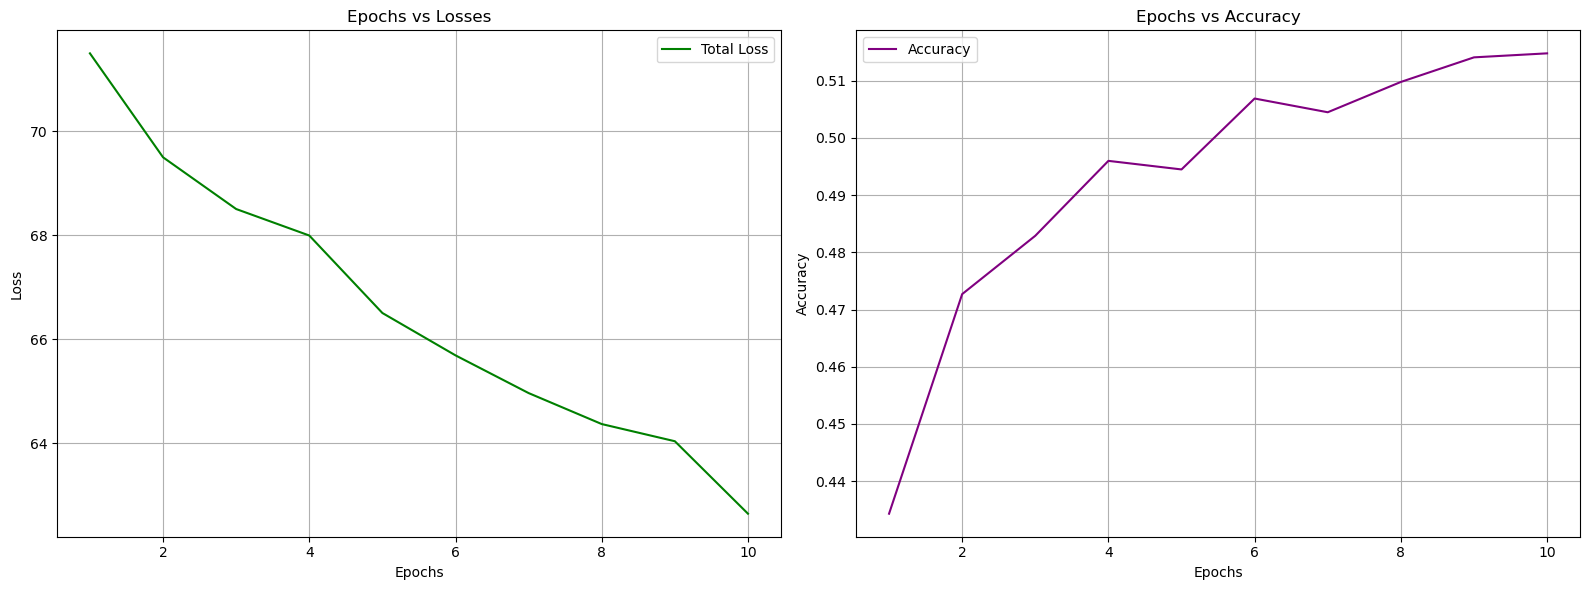

In [11]:
plt.figure(figsize=(16, 6))

# Plot epochs vs. total loss
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), best_losses_per_epoch, label='Total Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Losses')
plt.legend()
plt.grid(True)

# Plot epochs vs. accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), best_accuracies_per_epoch, label='Accuracy', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout() 
plt.show()


## Best Accuracy obtained = 51.48 % which is close to target percentage.